# Load libraries and data

In [1]:
# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
from tslearn.clustering import TimeSeriesKMeans, KShape
from tslearn.metrics import dtw
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
import copy
import sails
import umap.umap_ as umap

# Import custom functions
from functions import *

# sns.set(style='white', context='notebook')

In [2]:
# Loading sleep scoring data from MAT files stored in Google Drive.
# path_to_data = '/content/drive/My Drive/Donders Internship/2018-07-26_14-20-46_Post-Trial5/'
# data_file = 'PFClfpCleaned.mat'
# states_file = '2018-07-26_14-20-46_Post-Trial5-states.mat'

path_to_data = "./2018-07-26_14-20-46_Post-Trial5/"
data_file = 'PFClfpCleaned.mat'
states_file = '2018-07-26_14-20-46_Post-Trial5-states.mat'
pfc_data, sleep_scoring = load_mat_data(path_to_data, data_file, states_file)

nrem_epochs = np.array(get_all_NREM_epochs(sleep_scoring))

# Extract SO and Delta waves

In [3]:
# Get filtered NREM LFP data
fs = 1000
nrem_filtered_data, nrem_data = get_nrem_filtered(pfc_data, nrem_epochs, fs=fs)

C:\Users\nikhi\AppData\Roaming\Python\Python39\site-packages\neurodsp\filt\utils.py:90: RuntimeWarning: divide by zero encountered in log10
  db = 20 * np.log10(abs(h_vals))


In [4]:
# Get cycles using IP
IP, IF, IA = emd.spectra.frequency_transform(nrem_filtered_data, fs, 'hilbert')

C = emd.cycles.Cycles(IP)

 Checking Cycles inputs - trimming singleton from input 'IP'


In [6]:
cycles = get_cycles_with_metrics(C, nrem_filtered_data, IA, IF)

In [7]:
# Define thresholds to filter food cycles and subset them
metrics = cycles.get_metric_dataframe()
peak_thresh = np.percentile(metrics['peak_values'], 85)
trough_thresh = np.percentile(metrics['trough_values'], 40)
delta_peak_thresh = np.percentile(metrics['peak_values'], 40)

lo_freq_duration = fs/0.1
hi_freq_duration = fs/4

In [8]:
# Apply conditions to get good cycles
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              # f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}']

all_cycles = get_cycles_with_conditions(cycles, conditions)

In [9]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values>={peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
so_cycles = get_cycles_with_conditions(cycles, conditions)

In [10]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              ]
delta_cycles = get_cycles_with_conditions(cycles, conditions)

In [11]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              f'peak_values>{delta_peak_thresh}',
              ]
big_delta_cycles = get_cycles_with_conditions(delta_cycles, conditions)

In [12]:
conditions = ['is_good==1',
              # f'max_amp>{amp_thresh}',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'peak_values<{peak_thresh}',
              f'trough_values<={trough_thresh}',
              f'peak_values<={delta_peak_thresh}',
              ]
small_delta_cycles = get_cycles_with_conditions(delta_cycles, conditions)

In [15]:
metrics_so = so_cycles.get_metric_dataframe(subset=True)
metrics_delta = delta_cycles.get_metric_dataframe(subset=True)

(0.0, 600.0)

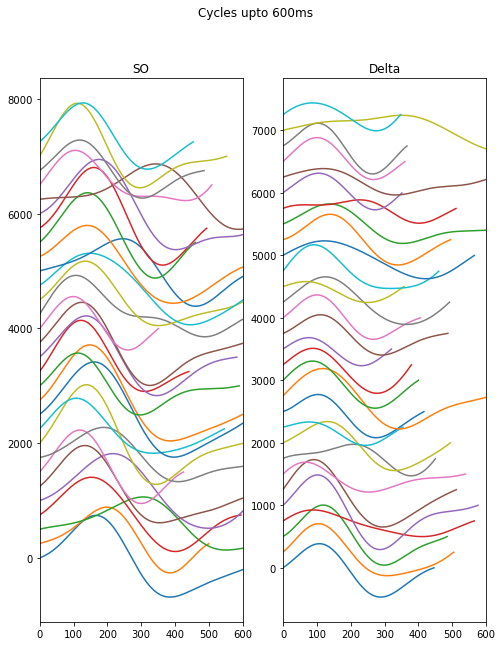

In [16]:
plt.figure(figsize=(8,10))
plt.suptitle("Cycles upto 600ms")

plt.subplot(1, 2, 1)
plt.title('SO')
start = 0
cycles_to_plot_so = np.random.choice(metrics_so['index'], 30)
for i in cycles_to_plot_so:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  plt.plot(cycle+start)
  start += 250
plt.xlim((0,600))

plt.subplot(1, 2, 2)
plt.title('Delta')
# plt.yticks([])
start = 0
cycles_to_plot_delta = np.random.choice(metrics_delta['index'], 30)
for i in cycles_to_plot_delta:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  plt.plot(cycle+start)
  start += 250
plt.xlim((0,600))

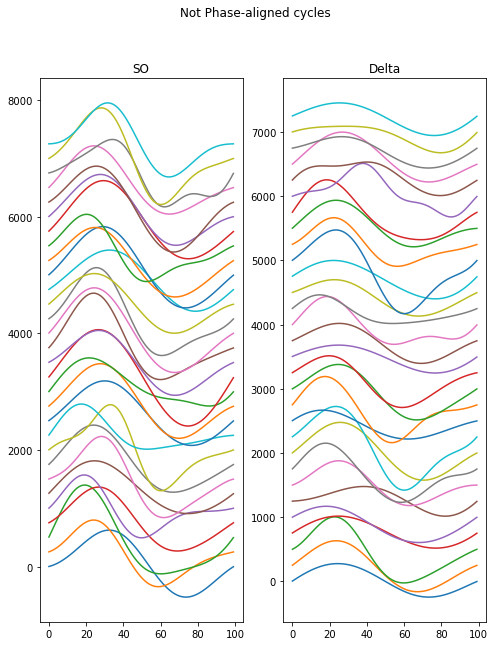

In [17]:
plt.figure(figsize=(8,10))
plt.suptitle("Not Phase-aligned cycles")

plt.subplot(1, 2, 1)
plt.title('SO')
# plt.yticks([])
start = 0
cycles_to_plot_so = np.random.choice(metrics_so['index'], 30)
for i in cycles_to_plot_so:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  new_length = 100
  new_indices = np.linspace(0, len(cycle) - 1, new_length)

  interpolator = interp1d(np.arange(len(cycle)), cycle, kind='linear')
  downsampled_series = interpolator(new_indices)

  plt.plot(downsampled_series+start)
  # plt.plot(so_waveforms[:,i]+start)
  start += 250

plt.subplot(1, 2, 2)
plt.title('Delta')
# plt.yticks([])
start = 0
cycles_to_plot_delta = np.random.choice(metrics_delta['index'], 30)
for i in cycles_to_plot_delta:
  inds = cycles.get_inds_of_cycle(i)
  cycle = nrem_filtered_data[inds]

  new_length = 100
  new_indices = np.linspace(0, len(cycle) - 1, new_length)

  interpolator = interp1d(np.arange(len(cycle)), cycle, kind='linear')
  downsampled_series = interpolator(new_indices)

  plt.plot(downsampled_series+start)
  start += 250

# Phase-aligned SO and Delta cycles

In [18]:
all_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=all_cycles.iterate(through='subset'), npoints=100)
all_waveforms.shape

 Checking phase_align inputs - trimming singleton from input 'ip'


(100, 2795)

In [19]:
so_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=so_cycles.iterate(through='subset'), npoints=100)
delta_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=delta_cycles.iterate(through='subset'), npoints=100)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


In [20]:
big_delta_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=big_delta_cycles.iterate(through='subset'), npoints=100)
small_delta_waveforms, _ = emd.cycles.phase_align(IP, nrem_filtered_data,
                                                            cycles=small_delta_cycles.iterate(through='subset'), npoints=100)

 Checking phase_align inputs - trimming singleton from input 'ip'
 Checking phase_align inputs - trimming singleton from input 'ip'


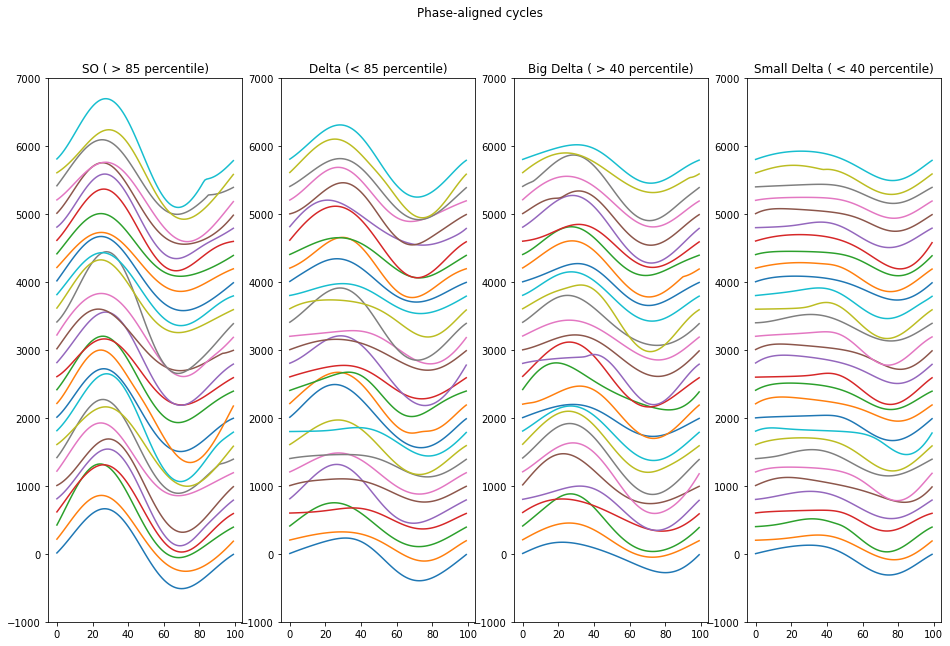

In [21]:
plt.figure(figsize=(16,10), facecolor='white')
plt.suptitle("Phase-aligned cycles")
plt.subplot(1, 4, 1)
plt.title('SO ( > 85 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, so_waveforms.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(so_waveforms[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 4, 2)
plt.title('Delta (< 85 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, delta_waveforms.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(delta_waveforms[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 4, 3)
plt.title('Big Delta ( > 40 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, big_delta_waveforms.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(big_delta_waveforms[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.subplot(1, 4, 4)
plt.title('Small Delta ( < 40 percentile)')
# plt.yticks([])
start = 0
cycles_to_plot = np.random.randint(1, small_delta_waveforms.shape[1], 30)
for i in cycles_to_plot:
  plt.plot(small_delta_waveforms[:,i]+start)
  start += 200
plt.ylim((-1000, 7000))

plt.savefig('Phase-align-cycles.svg')

# Rate of SO and delta cycles

In [ ]:
so_cycles_vector = get_masked_cycles(IP, so_cycles)
delta_cycles_vector = get_masked_cycles(IP, delta_cycles)

In [ ]:
# Visualize cycles in a segment
def visualize_cycle_segment(cycles_vector, segment, fs=1000, duration=10):
    x = cycles_vector[segment*fs*duration:(segment+1)*fs*duration]
    plt.plot(x)

visualize_cycle_segment(so_cycles_vector, 45)

In [ ]:
so_cycles_rates = rate_cycle(so_cycles_vector, duration=10, fs=1000)
delta_cycles_rates = rate_cycle(delta_cycles_vector, duration=10, fs=1000)

In [ ]:
np.corrcoef(so_cycles_rates, delta_cycles_rates)

In [ ]:
import seaborn as sns

sns.kdeplot(x=so_cycles_rates, y=delta_cycles_rates, fill=True)
ax = sns.scatterplot(x=so_cycles_rates, y=delta_cycles_rates)
ax.set(xlabel='SO cycles rates', ylabel='Delta Cycles rate')
plt.show()

In [ ]:
plt.figure(figsize=(16,10))

plt.subplot(2, 1, 1)
plt.title('SO')
plt.bar(range(len(so_cycles_rates)), so_cycles_rates, width=1.0)
plt.ylabel("Rate of SOs (Hz)")
plt.xlabel("Time (10 sec windows)")

plt.subplot(2, 1, 2)
plt.title('Delta')
plt.bar(range(len(delta_cycles_rates)), delta_cycles_rates, width=1.0)
plt.ylabel("Rate of Delta (Hz)")
plt.xlabel("Time (10 sec windows)")

plt.tight_layout()

In [ ]:
plt.hist(so_cycles_rates, bins=50);
plt.ylabel("Number of 10 sec windows")
plt.xlabel("Number of SOs in 10 sec window")